# **Introduction**


* Aim of this notebook is to run Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification using tensorflow.

# **Obtaining the Data**

## *Load the images folders & required libraries*

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import os, shutil, pathlib

train_dir = pathlib.Path("data/train")
new_base_dir = pathlib.Path("datacats_and_dogs_small")


def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=train_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## *Create Datasets for Images*

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory


data_folder = pathlib.Path('datacats_and_dogs_small')


train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [3]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [4]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


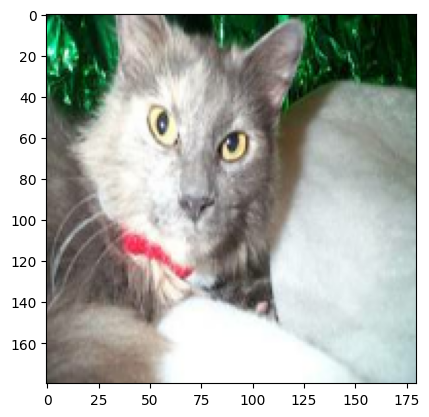

In [5]:
import matplotlib.pyplot as plt

plt.imshow(data_batch[0].numpy().astype("uint8"))

# **Exploratory Data Analysis**

* Aim of this section is to explore the dataset in some depth. This includes looking at some examples of each image, exploring the distribution of cat vs dog classes, and studying the image dimensions.

## *Display First 10 Cats & Dogs Images*

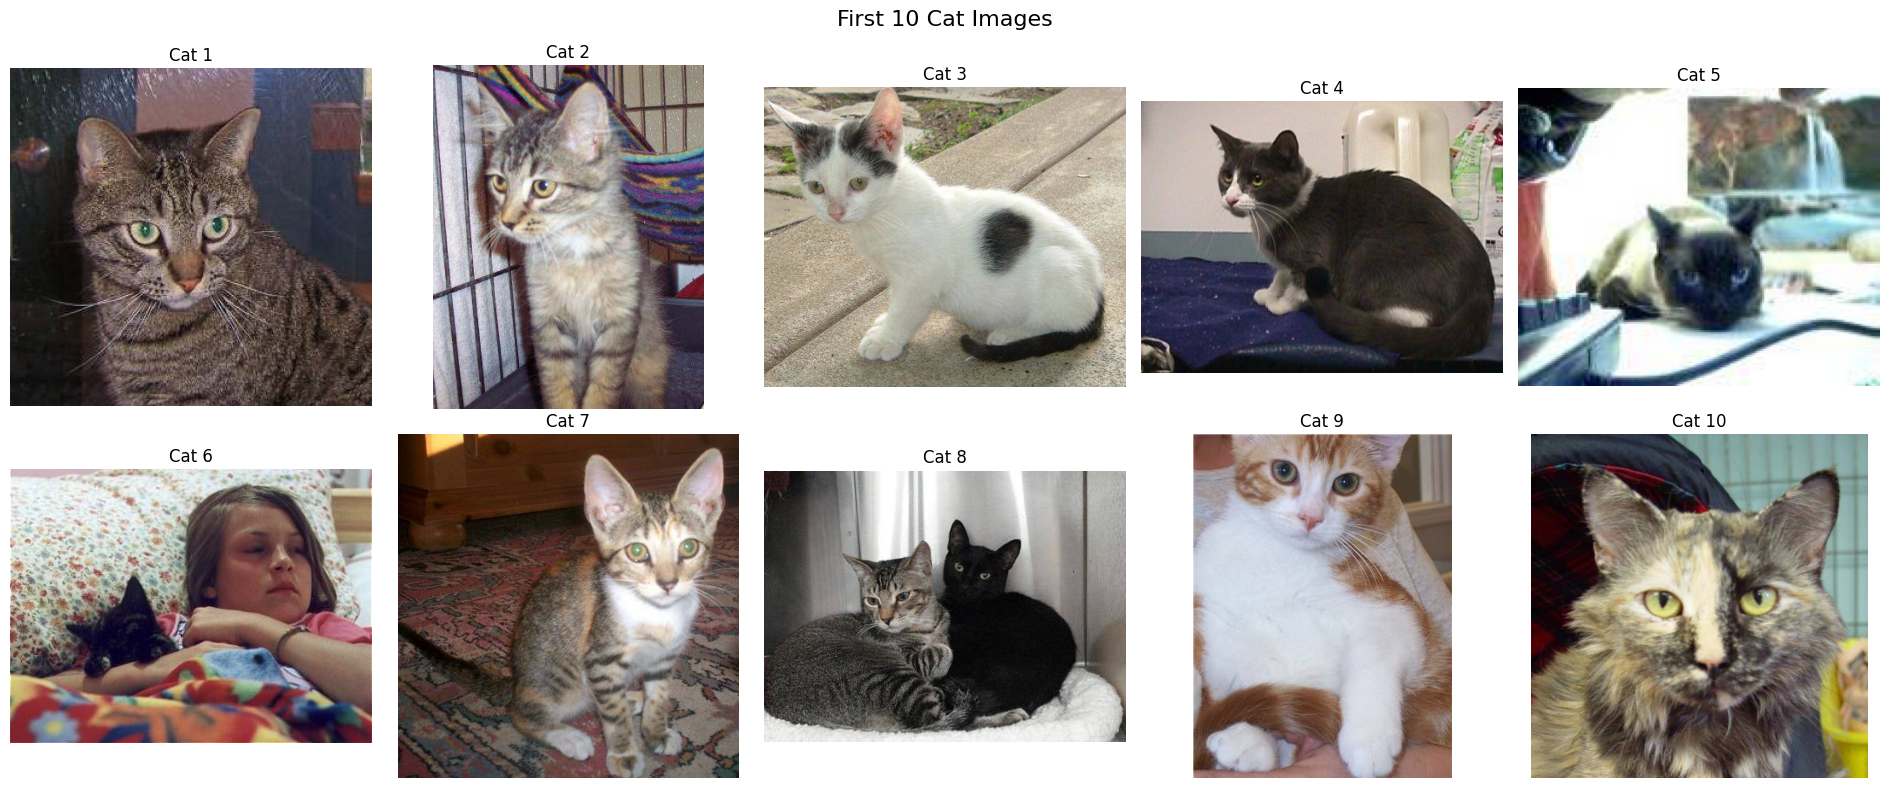

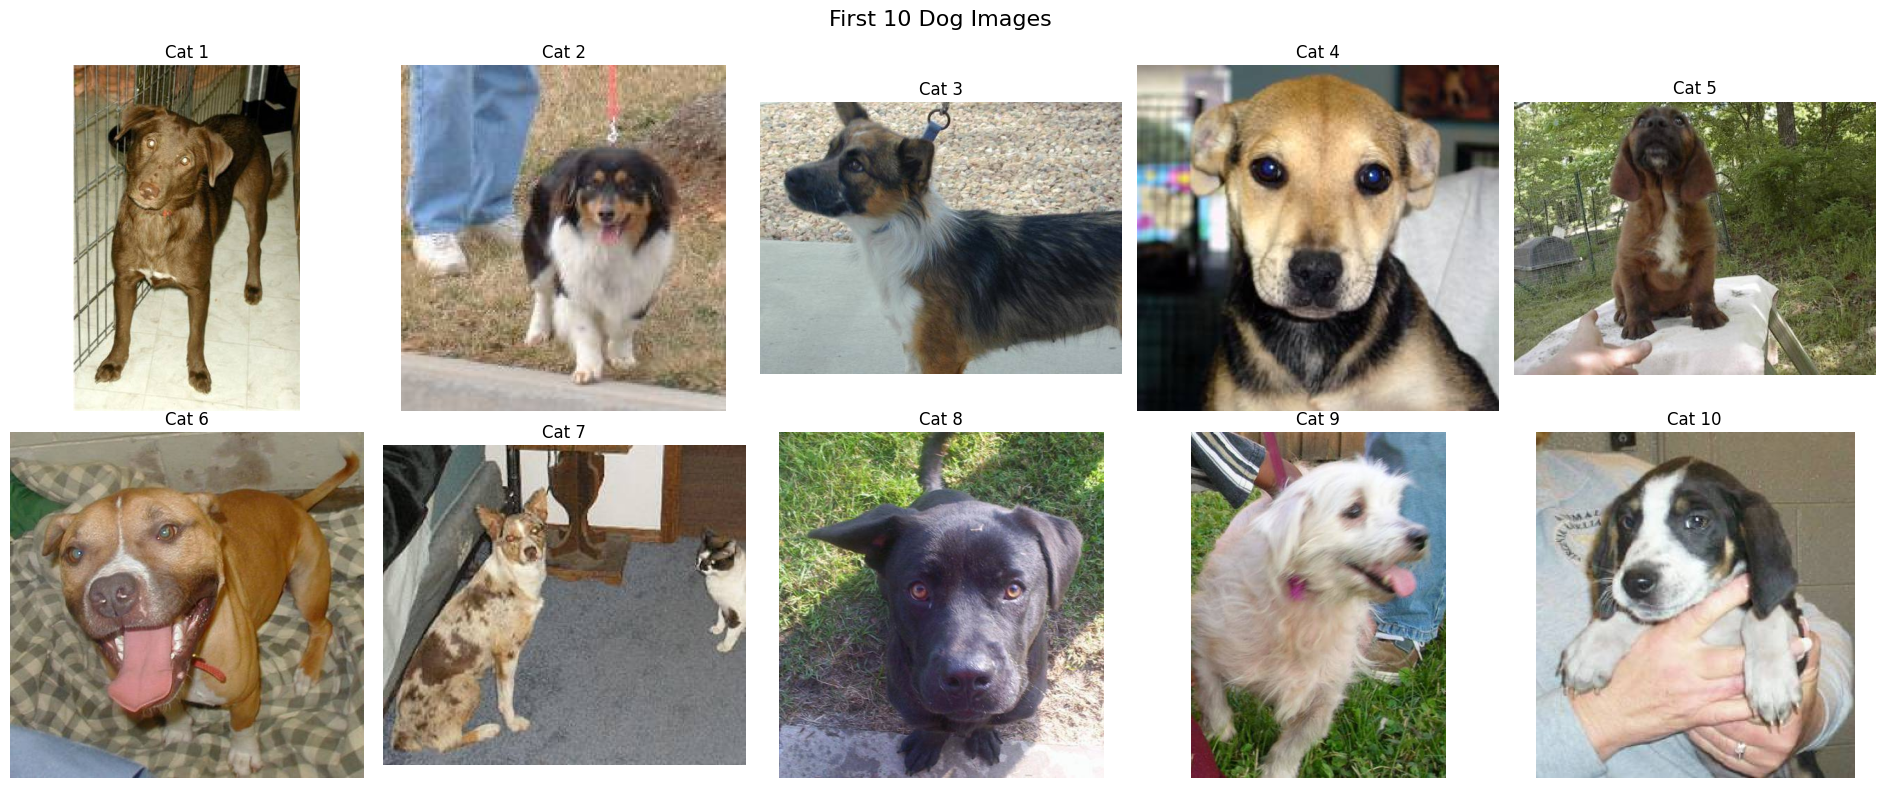

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

cols = 5
rows = 2  
fig = plt.figure(figsize=(4 * cols - 1, 4.5 * rows - 1))
for i in range(1, 11):
    img_path = f'datacats_and_dogs_small/train/cat/cat.{i}.jpg'  
    img = mpimg.imread(img_path)
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img)
    ax.set_title(f'Cat {i}')
    ax.axis('off') 
fig.suptitle('First 10 Cat Images', fontsize=16)  
plt.tight_layout() 
plt.show()
plt.close()

fig = plt.figure(figsize=(4 * cols - 1, 4.5 * rows - 1))
for i in range(1, 11):
    img_path = f'datacats_and_dogs_small/train/dog/dog.{i}.jpg'  
    img = mpimg.imread(img_path)
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img)
    ax.set_title(f'Cat {i}')
    ax.axis('off') 
fig.suptitle('First 10 Dog Images', fontsize=16)  
plt.tight_layout() 
plt.show()
plt.close()

## *Frequency of Cats & Dogs in Training Set*

<Axes: xlabel='category'>

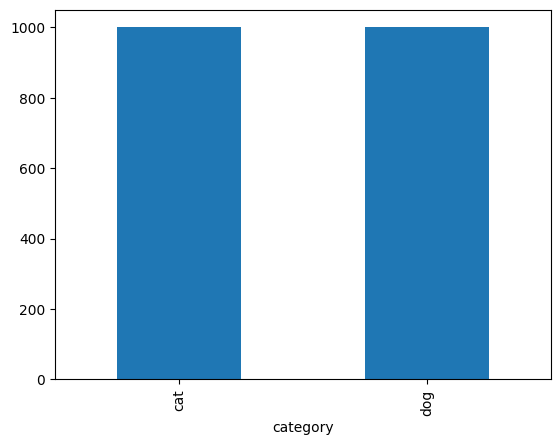

In [7]:
total_cats = len(os.listdir('datacats_and_dogs_small/train/cat'))
total_dogs = len(os.listdir('datacats_and_dogs_small/train/dog'))

pd.DataFrame({'category': ['cat', 'dog'], 'count': [total_cats, total_dogs]}).plot.bar(x='category', y='count', legend=False)

* Both Cats & Dogs have equal number images which indicates a balanced dataset.

## *Image Dimensions*

In [8]:
# function to get image dimensions
def get_image_dimensions(folder_path):
    image_dimensions = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.jpg'):
            image_path = os.path.join(folder_path, filename)
            img = mpimg.imread(image_path)
            if img is not None:  
                height, width, _ = img.shape
                image_dimensions.append((filename, width, height))
    return image_dimensions

cat_folder_path = 'datacats_and_dogs_small/train/cat'
dog_folder_path = 'datacats_and_dogs_small/train/dog'
# tuples with dimensions of images
cat_dimensions = get_image_dimensions(cat_folder_path)
dog_dimensions = get_image_dimensions(dog_folder_path)

# Convert the list of tuples to a DataFrame
cat_df = pd.DataFrame(cat_dimensions, columns=['filename', 'width', 'height'])
dog_df = pd.DataFrame(dog_dimensions, columns=['filename', 'width', 'height'])


### *1. Distribution of Heights*

<Figure size 1200x600 with 0 Axes>

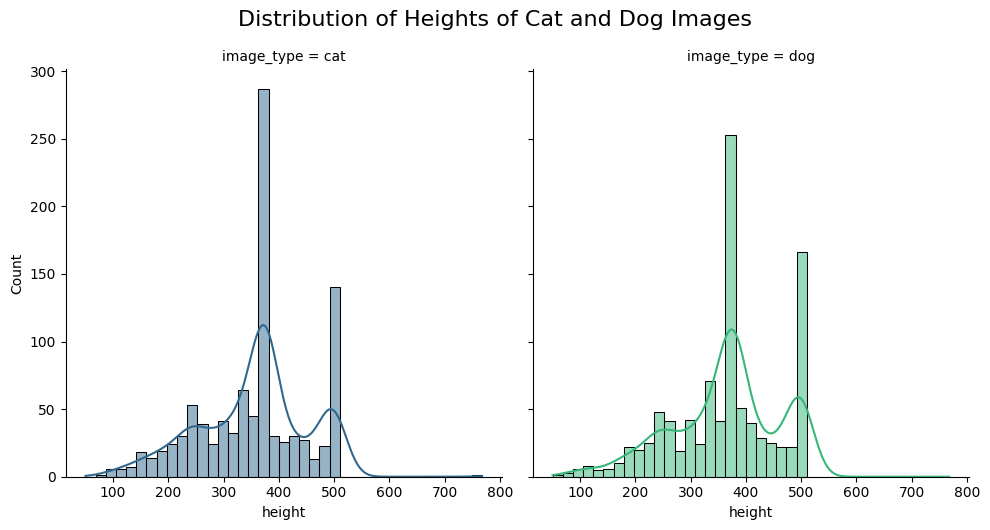

In [9]:
combined_height_df = pd.concat([
    cat_df[['height']].assign(image_type='cat'),
    dog_df[['height']].assign(image_type='dog')
])

fig = plt.figure(figsize=(12, 6))
sns.displot(data=combined_height_df, x='height', hue='image_type', kde=True,col='image_type', palette='viridis',legend=False)
plt.suptitle('Distribution of Heights of Cat and Dog Images', x=0.5, y=1.05, ha='center', fontsize=16) 
plt.show()

### *2. Distribution of Width*

<Figure size 1200x600 with 0 Axes>

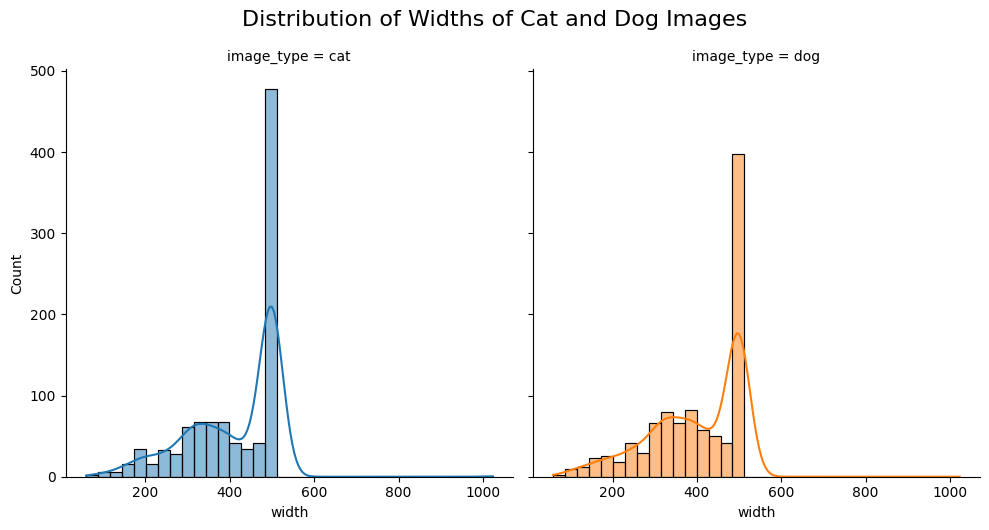

In [10]:
combined_width_df = pd.concat([
    cat_df[['width']].assign(image_type='cat'),
    dog_df[['width']].assign(image_type='dog')
])

fig = plt.figure(figsize=(12, 6))
sns.displot(data=combined_width_df, x='width', hue='image_type', kde=True,col='image_type',legend=False)
plt.suptitle('Distribution of Widths of Cat and Dog Images', x=0.5, y=1.05, ha='center', fontsize=16) 
plt.show()

# **Model Creation**

## *Model 1*

In [11]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [13]:
model_1.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [14]:
checkpoint_filepath = 'best_model_model1_copy.hdf5' 

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor="val_loss",
        mode='min')
]
history_1 = model_1.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


63/63 [==============================] - 46s 727ms/step - loss: 0.7130 - accuracy: 0.5160 - val_loss: 0.6921 - val_accuracy: 0.5860
Epoch 2/30
63/63 [==============================] - 52s 820ms/step - loss: 0.6966 - accuracy: 0.5235 - val_loss: 0.7221 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 47s 748ms/step - loss: 0.6847 - accuracy: 0.5655 - val_loss: 0.6552 - val_accuracy: 0.6110
Epoch 4/30
63/63 [==============================] - 48s 761ms/step - loss: 0.6405 - accuracy: 0.6550 - val_loss: 0.6578 - val_accuracy: 0.6410
Epoch 5/30
63/63 [==============================] - 49s 770ms/step - loss: 0.6075 - accuracy: 0.6565 - val_loss: 0.6766 - val_accuracy: 0.6060
Epoch 6/30
63/63 [==============================] - 50s 796ms/step - loss: 0.5756 - accuracy: 0.6925 - val_loss: 0.6132 - val_accuracy: 0.6610
Epoch 7/30
63/63 [==============================] - 53s 833ms/step - loss: 0.5604 - accuracy: 0.7160 - val_loss: 0.6197 - val_accuracy: 0.6760
Epoch 8/30

### *Plots for Evaluating the model*

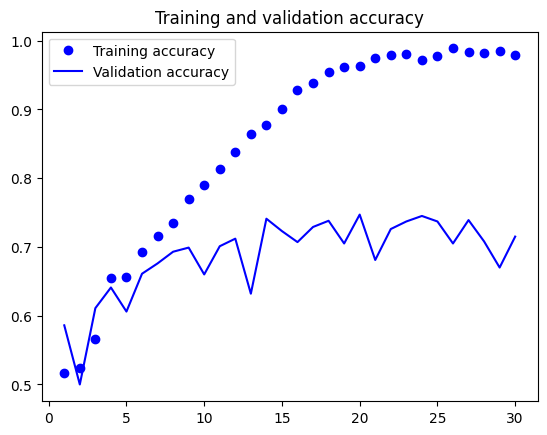

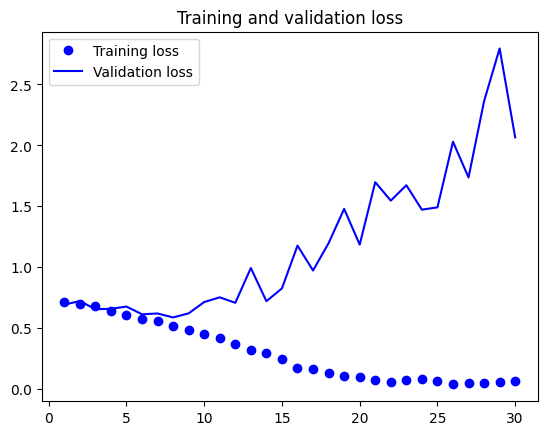

In [15]:
accuracy = history_1.history["accuracy"]
val_accuracy = history_1.history["val_accuracy"]
loss = history_1.history["loss"]
val_loss = history_1.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### *Testing the model with test set*

In [16]:
test_model_1 = keras.models.load_model(
    "best_model_model1.hdf5")
test_loss_1, test_acc_1 = test_model_1.evaluate(test_dataset)
print(f"Test accuracy: {test_acc_1:.3f}")

63/63 [==============================] - 14s 219ms/step - loss: 1.1131 - accuracy: 0.7290
Test accuracy: 0.729


In [17]:
history_1_dict = history_1.history
hist_df_1 = pd.DataFrame(history_1_dict)
hist_df_1


loss  accuracy  val_loss  val_accuracy
0   0.713015    0.5160  0.692076         0.586
1   0.696564    0.5235  0.722122         0.500
2   0.684678    0.5655  0.655198         0.611
3   0.640484    0.6550  0.657761         0.641
4   0.607469    0.6565  0.676594         0.606
5   0.575559    0.6925  0.613168         0.661
6   0.560372    0.7160  0.619738         0.676
7   0.515783    0.7350  0.587357         0.693
8   0.484195    0.7690  0.620832         0.699
9   0.455219    0.7905  0.713530         0.660
10  0.419528    0.8135  0.752285         0.701
11  0.372983    0.8375  0.707385         0.712
12  0.318205    0.8645  0.992980         0.632
13  0.296675    0.8775  0.720664         0.741
14  0.244807    0.9000  0.825889         0.723
15  0.175319    0.9285  1.177084         0.707
16  0.161705    0.9380  0.972517         0.729
17  0.130194    0.9550  1.196969         0.738
18  0.104024    0.9620  1.478766         0.705
19  0.100650    0.9635  1.185195         0.747
20  0.074881    0.9740  1.697806         0.681
21  0.058640    0.9785  1.546249         0.726
22  0.070146    0.9800  1.672654         0.737
23  0.080200    0.9715  1.472115         0.745
24  0.061488    0.9775  1.490953         0.737
25  0.036924    0.9885  2.029843         0.705
26  0.048272    0.9835  1.736598         0.739
27  0.050037    0.9815  2.362741         0.708
28  0.054592    0.9855  2.795363         0.670
29  0.068986    0.9785  2.065430         0.715

## *Conclusions*

**Training & Validation loss**
* This model performs well on the training data but not on validation data.
* The validation loss start to increase after epoch 10. The model have less loss until the epoch 10.
* This means that the model was trying to stabilize to a point till epoch 10.
* The gap between validation and training loss is very high.
* This is an indicator of overfitting.

**Accuracy**

* We are getting good accuracy for training set.
* But for validation accuracy, it has started to keep on same value range after epoch 10. 
* For test set, we are getting accuracy of .729. This means that 72.9 % of images are predicted correctly by the model.

**Weights**
* The best set of weights seems to correspond to epoch 13, where val_accuracy is the highest (0.741) and val_loss is relatively low compared to other epochs (0.720664).

## *Model 2 - Fine Tuning with vgg16*

In [18]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [19]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### *Preprocessing the input*

In [20]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 1s/step


### *Freezing the model weights*

In [21]:
conv_base.trainable = False
conv_base.summary(
)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### *Create Model with Convolutional base*

In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = keras.Model(inputs, outputs)

In [23]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                           

In [24]:
model_2.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


checkpoint_filepath = 'best_model_copy.hdf5' 

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor="val_loss",
        mode='min')]

In [25]:
history_2 = model_2.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


63/63 [==============================] - 280s 4s/step - loss: 17.1685 - accuracy: 0.8895 - val_loss: 4.9841 - val_accuracy: 0.9650
Epoch 2/50
63/63 [==============================] - 275s 4s/step - loss: 6.1005 - accuracy: 0.9440 - val_loss: 3.5135 - val_accuracy: 0.9740
Epoch 3/50
63/63 [==============================] - 274s 4s/step - loss: 4.5690 - accuracy: 0.9555 - val_loss: 7.9375 - val_accuracy: 0.9560
Epoch 4/50
63/63 [==============================] - 275s 4s/step - loss: 4.8805 - accuracy: 0.9600 - val_loss: 3.7878 - val_accuracy: 0.9780
Epoch 5/50
63/63 [==============================] - 275s 4s/step - loss: 4.3384 - accuracy: 0.9570 - val_loss: 3.4223 - val_accuracy: 0.9740
Epoch 6/50
63/63 [==============================] - 278s 4s/step - loss: 3.0382 - accuracy: 0.9710 - val_loss: 5.0258 - val_accuracy: 0.9700
Epoch 7/50
63/63 [==============================] - 277s 4s/step - loss: 4.6583 - accuracy: 0.9675 - val_loss: 7.0391 - val_accuracy: 0.9630
Epoch 8/50
63/63 [=====

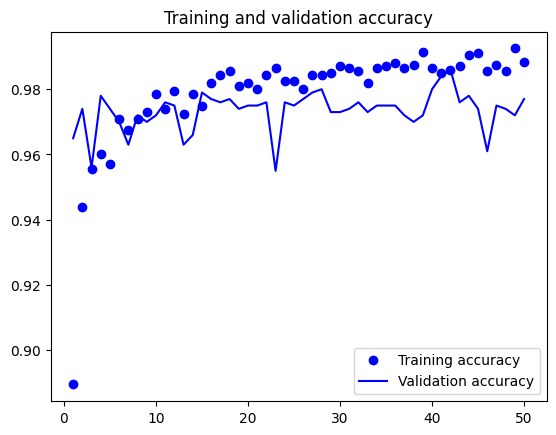

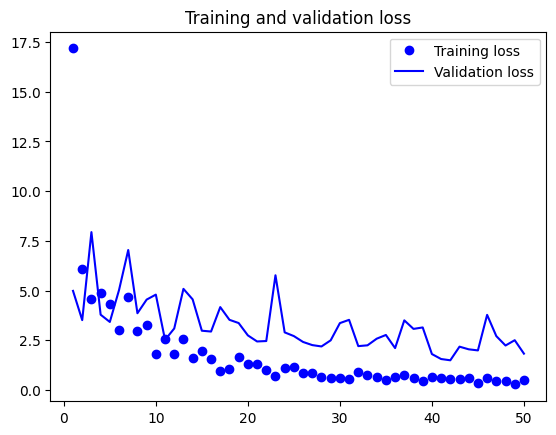

In [26]:
acc = history_2.history["accuracy"]
val_acc = history_2.history["val_accuracy"]
loss = history_2.history["loss"]
val_loss = history_2.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### *Evaluate the model with test set*

In [27]:
test_model_2 = keras.models.load_model(
    "best_model.hdf5")
test_loss_2, test_acc_2 = test_model_2.evaluate(test_dataset)
print(f"Test accuracy: {test_acc_2:.3f}")

63/63 [==============================] - 202s 3s/step - loss: 2.4849 - accuracy: 0.9765
Test accuracy: 0.976


In [28]:
history_2_dict = history_2.history
hist_df_2 = pd.DataFrame(history_2_dict)
hist_df_2


loss  accuracy  val_loss  val_accuracy
0   17.168463    0.8895  4.984055         0.965
1    6.100548    0.9440  3.513541         0.974
2    4.568997    0.9555  7.937505         0.956
3    4.880500    0.9600  3.787812         0.978
4    4.338428    0.9570  3.422342         0.974
5    3.038173    0.9710  5.025804         0.970
6    4.658338    0.9675  7.039078         0.963
7    2.984732    0.9710  3.860712         0.972
8    3.273030    0.9730  4.545559         0.970
9    1.804847    0.9785  4.796463         0.972
10   2.569045    0.9740  2.521694         0.976
11   1.796767    0.9795  3.094885         0.975
12   2.565411    0.9725  5.085546         0.963
13   1.623403    0.9785  4.557412         0.966
14   1.942382    0.9750  2.981691         0.979
15   1.570130    0.9820  2.940545         0.977
16   0.935390    0.9845  4.168601         0.976
17   1.073169    0.9855  3.529336         0.977
18   1.669256    0.9810  3.367442         0.974
19   1.327880    0.9820  2.747477         0.975
20   1.328078    0.9800  2.441870         0.975
21   1.010675    0.9845  2.462678         0.976
22   0.684676    0.9865  5.768030         0.955
23   1.097286    0.9825  2.898780         0.976
24   1.143521    0.9825  2.711579         0.975
25   0.862628    0.9800  2.416454         0.977
26   0.859436    0.9845  2.258896         0.979
27   0.652574    0.9845  2.190644         0.980
28   0.593573    0.9850  2.498260         0.973
29   0.610646    0.9870  3.363908         0.973
30   0.574804    0.9865  3.528352         0.974
31   0.921167    0.9855  2.207339         0.976
32   0.730911    0.9820  2.247656         0.973
33   0.673076    0.9865  2.580405         0.975
34   0.529604    0.9870  2.768208         0.975
35   0.638289    0.9880  2.107959         0.975
36   0.741914    0.9865  3.502442         0.972
37   0.584667    0.9875  3.073118         0.970
38   0.445315    0.9915  3.146147         0.972
39   0.655612    0.9865  1.808740         0.980
40   0.596796    0.9850  1.558759         0.984
41   0.538528    0.9860  1.495353         0.986
42   0.578584    0.9870  2.180365         0.976
43   0.628239    0.9905  2.046947         0.978
44   0.337693    0.9910  1.991745         0.974
45   0.625182    0.9855  3.778216         0.961
46   0.462508    0.9875  2.710402         0.975
47   0.472815    0.9855  2.237985         0.974
48   0.279399    0.9925  2.504649         0.972
49   0.522063    0.9885  1.829930         0.977

## *Conclusions*

**Training & Validation loss**
* This model performs well on the training data and validation data.
* This model shows a best fit.
* The gap between validation and training loss is very low.
* This is an indicator of best fit model.

**Accuracy**

* We are getting good accuracy for training set and validation set.
* The accuracy on test set is .976.
* This means that 97.6 % of the images are correctly predicted by the model.

**Weights**
* The best set of weights seems to correspond to epoch 35, where val_accuracy is the highest (0.981) and val_loss is relatively low compared to other epochs (1.629161).


**Summarised Conclusion is give below**

| Model Name | Highest Val Accuracy | Val_Loss | Epoch |
|------------|----------------------|----------|-------|
| Model_1    |         0.741            |   0.720664	       |  13     |
| Model_2 Fine Tuning   |      0.981                |    1.629161      |    35   |	


**Accuracy for test set**
<table>
  <thead>
    <tr>
      <th>Model Name</th>
      <th>Accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Model_1</td>
      <td>0.729</td>
    </tr>
    <tr>
      <td>Model_2 Fine Tuning</td>
      <td>0.976</td>
    </tr>
  </tbody>
</table>


# **Relative performance of the models**

**I am using ImageDatagenerator in this step to get lables and features for validation dataset.**

In [29]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

validation_dir = 'datacats_and_dogs_small/validation'

img_height, img_width = 180, 180  
batch_size = 32  
validation_image_generator = ImageDataGenerator(rescale=1./255)

val_data_gen   = validation_image_generator.flow_from_directory(
                    validation_dir,
                    target_size=(img_height, img_width),
                    batch_size=batch_size,
                    class_mode='binary')

Found 1000 images belonging to 2 classes.


### **Model 1**

**Accuracy**

In [30]:
# Load the best model
model1_new = load_model('best_model_model1.hdf5')
y_pred_model1 = model1_new.predict(val_data_gen)
y_pred_class_model1 = np.round(y_pred_model1).astype(int)
validation_labels = val_data_gen.classes

accuracy_model1 = accuracy_score(validation_labels, y_pred_class_model1)
print("Accuracy - Model 1:", accuracy_model1)

32/32 [==============================] - 6s 184ms/step
Accuracy - Model 1: 0.5


**Confusion Matrix**

<Axes: >

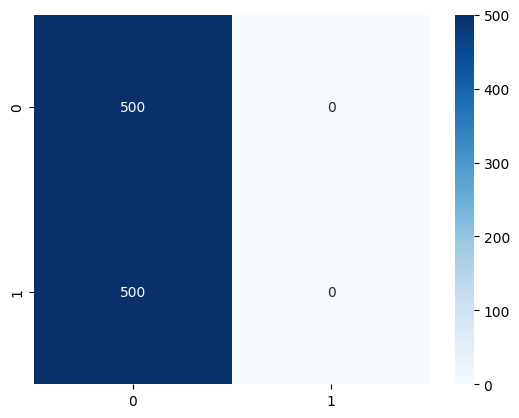

In [31]:
# Confusion matrix
conf_matrix_model1 = confusion_matrix(validation_labels, y_pred_class_model1)
sns.heatmap(conf_matrix_model1, annot=True, fmt='d', cmap='Blues')

**Precision, Recall, F1-Score**

In [32]:
# Generate classification report
report = classification_report(validation_labels, y_pred_class_model1, output_dict=True)

# Convert report to pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Display the report
display(report_df)

precision  recall  f1-score  support
0                  0.50     1.0  0.666667    500.0
1                  0.00     0.0  0.000000    500.0
accuracy           0.50     0.5  0.500000      0.5
macro avg          0.25     0.5  0.333333   1000.0
weighted avg       0.25     0.5  0.333333   1000.0

**Precision-Recall Curve**

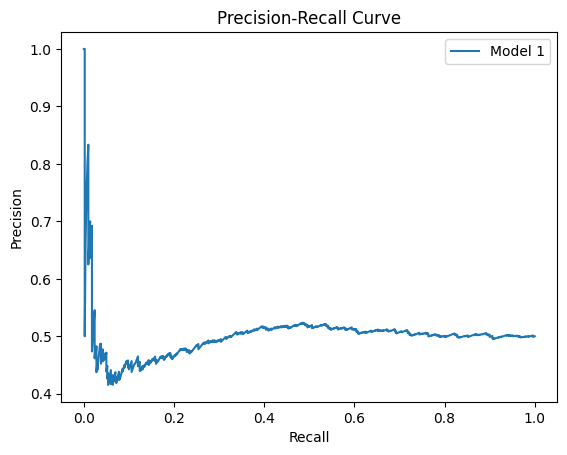

In [33]:
# Precision-Recall curve
precision_model1, recall_model1, _ = precision_recall_curve(validation_labels, y_pred_model1)
plt.plot(recall_model1, precision_model1, label='Model 1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

### **Model 2**

**Accuracy**

In [34]:
# Load the best model
model2_new = load_model('best_model.hdf5')
y_pred_model2 = model2_new.predict(val_data_gen)
y_pred_class_model2 = np.round(y_pred_model2).astype(int)

accuracy_model2 = accuracy_score(validation_labels, y_pred_class_model2)
print("Accuracy - Model 2:", accuracy_model2)

32/32 [==============================] - 101s 3s/step
Accuracy - Model 2: 0.5


**Confusion matrix**

<Axes: >

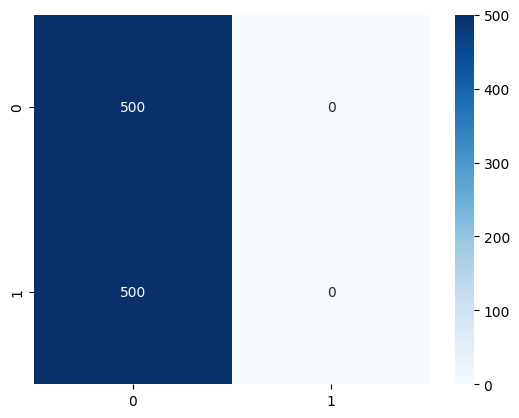

In [35]:
# Confusion matrix
conf_matrix_model2 = confusion_matrix(validation_labels, y_pred_class_model2)
sns.heatmap(conf_matrix_model2, annot=True, fmt='d', cmap='Blues')

In [36]:
# Generate classification report
report_2 = classification_report(validation_labels, y_pred_class_model2, output_dict=True)

# Convert report to pandas DataFrame
report_df_2 = pd.DataFrame(report_2).transpose()

# Display the report
display(report_df_2)

precision  recall  f1-score  support
0                  0.50     1.0  0.666667    500.0
1                  0.00     0.0  0.000000    500.0
accuracy           0.50     0.5  0.500000      0.5
macro avg          0.25     0.5  0.333333   1000.0
weighted avg       0.25     0.5  0.333333   1000.0

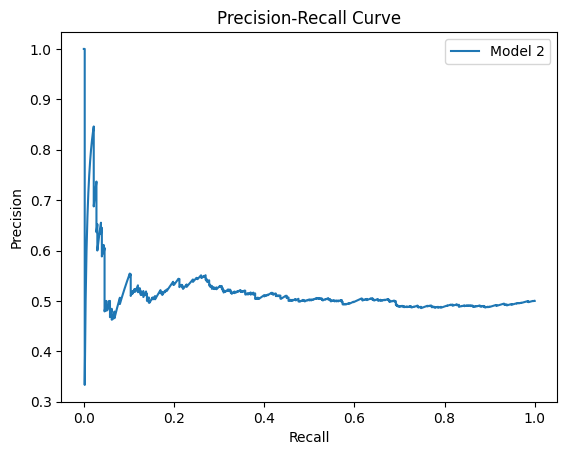

In [37]:
# Precision-Recall curve
precision_model2, recall_model2, _ = precision_recall_curve(validation_labels, y_pred_model2)
plt.plot(recall_model2, precision_model2, label='Model 2')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# **Conclusions**

* Fine tuning with vgg16 has good accuracy in test set.
* It has a accuracy of .976 fo test set.
* That means the model is able to predict 97.6 % of images correctly.
* The precision recall curve for model 2 is closer to top left corner of the graph than model 1 which means for a given level of recall model 2 has high precision.
* So Model 2 (vgg16) is the good model.